In [1]:
import os

from arch import arch_model
from forcast_utils import preprocessing, visualisation, base_fn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss

VOLATILITY_WINDOW = 20  # Window size for calculating volatility in days
FORECAST_TIMESERIES_LENGTH = 300  # Length of the time series to use for training
SCALE_FACTOR = 100  # Factor to scale the volatility for better visualisation




We will create a baseline GARCH model to predict volatility.
After that we will compare it with the LSTM model.

In [2]:
# download the BTC data
current_path = base_fn.get_current_path() # workaround for the jupyter notebook
btc = pd.read_csv(current_path +"/data/BTC_USD-15min.csv", parse_dates=['Open time'], index_col='Open time')

data = preprocessing.preprocess_15_min_data(btc.copy(), target_column="Target", feature_columns=['Open', 'High', 'Low', 'Close', 'Volume'], window=VOLATILITY_WINDOW)
data_preprocessed = preprocessing.drop_columns(data.copy(), ['Open', 'High', 'Low', 'Close', 'Volume', f'Log_Returns_{VOLATILITY_WINDOW}_Volatility'])
data.info()
data.head()

                Open      High       Low     Close        Volume  \
Open time                                                          
2018-01-01  13715.65  13818.55  12750.00  13380.00   8609.915844   
2018-01-02  13382.16  15473.49  12890.02  14675.11  20078.092111   
2018-01-03  14690.00  15307.56  14150.00  14919.51  15905.667639   
2018-01-04  14919.51  15280.00  13918.04  15059.54  21329.649574   
2018-01-05  15059.56  17176.24  14600.00  16960.39  23251.491125   

            Standard_Realized_Volatility  
Open time                                 
2018-01-01                      0.067739  
2018-01-02                      0.086601  
2018-01-03                      0.061617  
2018-01-04                      0.064098  
2018-01-05                      0.072525  
Using base column: Log_Returns_20_Volatility_Variance to create target column: Target
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2693 entries, 0 to 2692
Data columns (total 12 columns):
 #   Column                  

,Open,High,Low,Close,Volume,Standard_Realized_Volatility,Target,Log_Returns_20_Volatility,Log_Returns,Log_Returns_20_Volatility_Variance,Close_Returns,Close_Returns_20_Volatility
0,11530.00,11926.35,9900.24,10760.05,43752.606791,0.116018,0.006598,0.078773,-0.069112,0.006205,-0.066778,0.076152
1,10760.05,11399.00,9905.00,10799.18,37473.922552,0.093099,0.006205,0.078550,0.003630,0.006170,0.003637,0.075945
2,10799.14,11570.48,10500.00,11349.99,27158.587762,0.077998,0.006170,0.079751,0.049747,0.006360,0.051005,0.077156
3,11349.96,11794.05,10950.21,11175.27,20839.954183,0.056921,0.006360,0.073360,-0.015514,0.005382,-0.015394,0.070062
4,11184.70,11643.00,10311.15,11089.00,33056.871960,0.073496,0.005382,0.073150,-0.007750,0.005351,-0.007720,0.069872


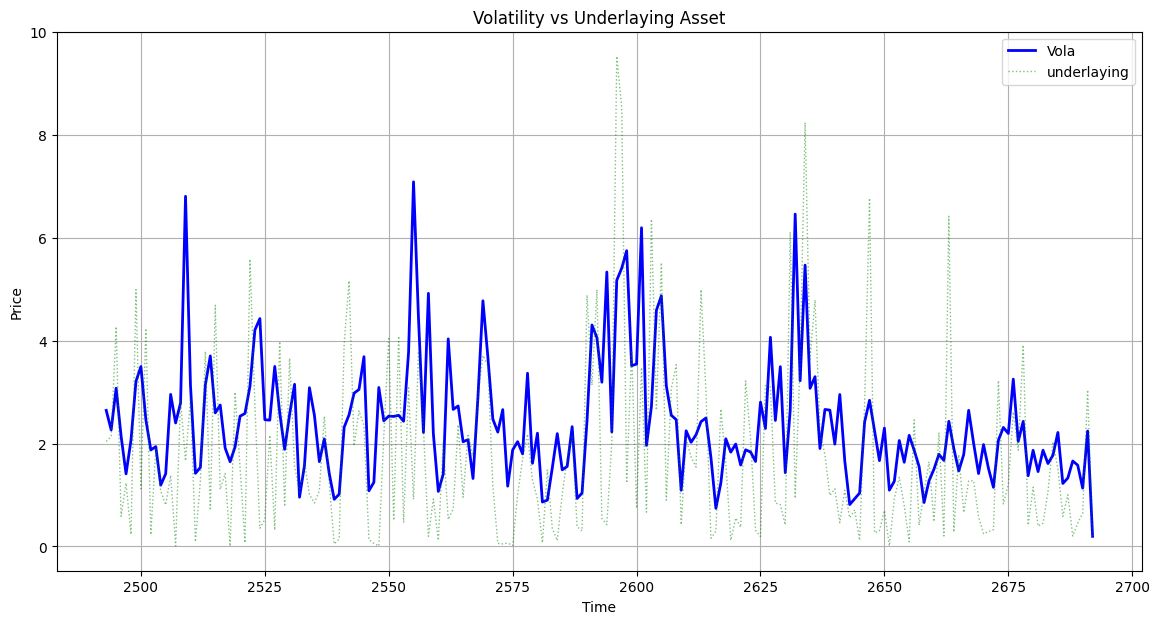

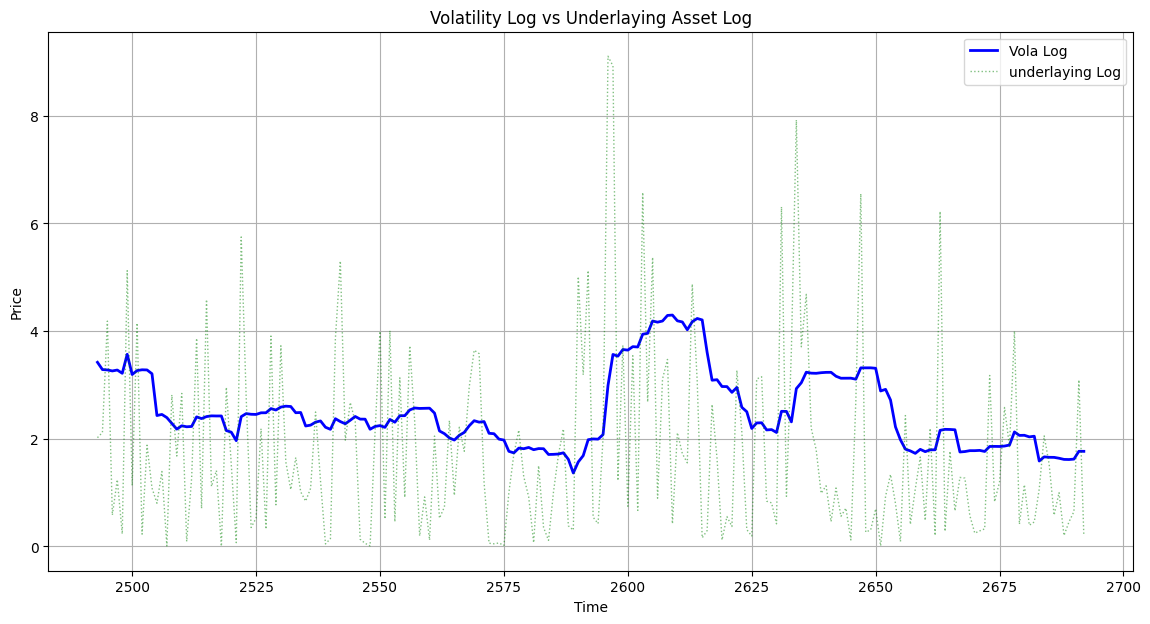

In [3]:
underlaying_log_full = data['Log_Returns'].copy().abs()
underlaying_log = underlaying_log_full[-200:]
#underlaying = data["Close"].copy()[-100:]
vola_log_full = data[f'Log_Returns_{VOLATILITY_WINDOW}_Volatility'].copy()
vola_log = vola_log_full[-200:]


underlaying = data["Close_Returns"].copy().abs()[-200:]
underlaying_full = data["Close_Returns"].copy()
vola_full = data[f'Standard_Realized_Volatility'].copy()
vola = vola_full[-200:]

# scale the underlaying and log by 10 for better visualisation

underlaying = underlaying.apply(lambda x: SCALE_FACTOR*x)
underlaying_full = underlaying_full.apply(lambda x: SCALE_FACTOR*x)
underlaying_log = underlaying_log.apply(lambda x: SCALE_FACTOR*x)
underlaying_log_full = underlaying_log_full.apply(lambda x: SCALE_FACTOR*x)
vola = vola.apply(lambda x: SCALE_FACTOR*x)
vola_log = vola_log.apply(lambda x: SCALE_FACTOR*x)
vola_log_full = vola_log_full.apply(lambda x: SCALE_FACTOR*x)
vola_full = vola_full.apply(lambda x: SCALE_FACTOR*x)
# Visualise the data


visualisation.visualize_forcast(vola, base_assest=underlaying, label_forcast="Vola", label_base_asset="underlaying", title="Volatility vs Underlaying Asset")
visualisation.visualize_forcast(vola_log, base_assest=underlaying_log, label_forcast="Vola Log", label_base_asset="underlaying Log", title="Volatility Log vs Underlaying Asset Log")



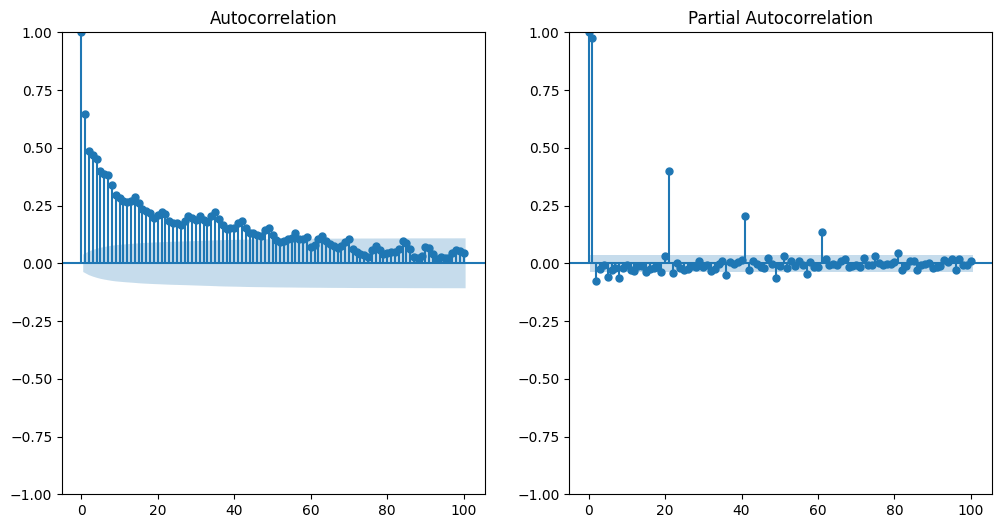

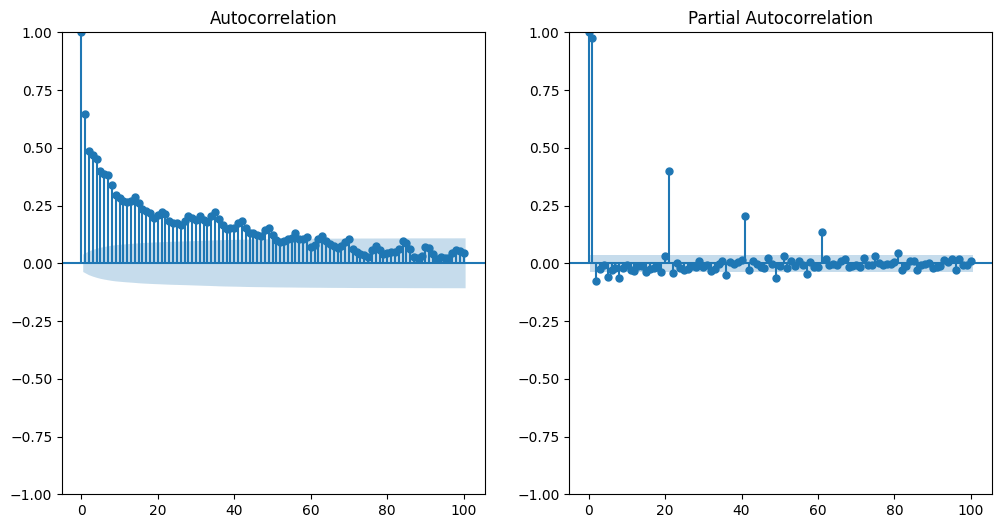

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# Plot ACF and PACF of the residuals
plt.figure(figsize=(12, 6))
plot_acf(vola_full, lags=100, ax=plt.subplot(121))
plot_pacf(vola_log_full, lags=100, ax=plt.subplot(122))

In [5]:
# Check if the time series is stationary using ADF and KPSS tests
def check_stationarity(series):
    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c')
    print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")
    print(f"KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}")
    if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")
check_stationarity(underlaying_full)

ADF Statistic: -36.22158819592953, p-value: 0.0
KPSS Statistic: 0.11499177512742186, p-value: 0.1
The series is stationary.


/var/folders/k2/txrs3kj16m3bkd90r_g83kj00000gn/T/ipykernel_68012/1476903911.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')


In [6]:
X_train, X_test = train_test_split(underlaying_full, test_size=FORECAST_TIMESERIES_LENGTH, random_state=42, shuffle=False)
print(X_train.shape, X_test.shape)


(2393,) (300,)


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                Close_Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6051.47
Distribution:      Standardized Student's t   AIC:                           12114.9
Method:                  Maximum Likelihood   BIC:                           12149.6
                                              No. Observations:                 2393
Date:                      Sat, Jun 07 2025   Df Residuals:                     2392
Time:                              14:11:57   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

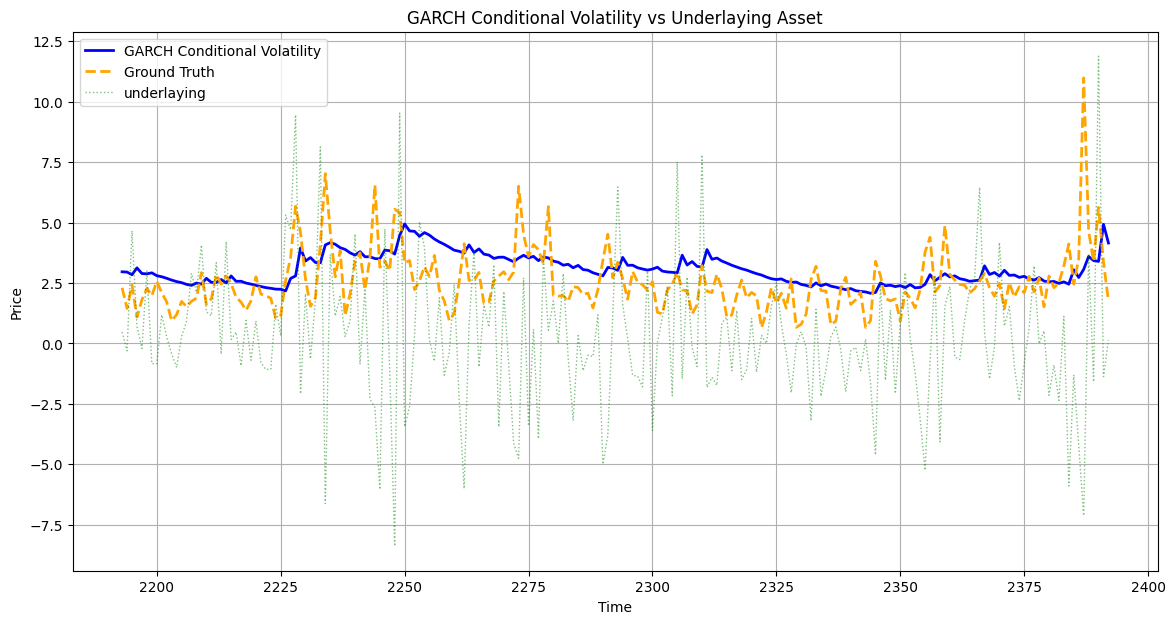

In [17]:
# train the GARCH(1, 1) model
garch = arch_model(X_train, vol='GARCH',p=1, q=2, mean='Constant', dist='t')
garch_fit = garch.fit(disp="off")
conditional_volatility = garch_fit.conditional_volatility
vola_log_full_without_test = vola_full[:-X_test.shape[0]]
print(garch_fit.summary())

forcast = garch_fit.forecast(horizon=FORECAST_TIMESERIES_LENGTH, reindex=False)
forcast_vola_viz = pd.Series(np.reshape(forcast.variance, (FORECAST_TIMESERIES_LENGTH,))).apply(lambda x: np.sqrt(x))

X_test_viz = X_test.reset_index(drop=True)
test_vola_viz = vola_log_full[-X_test.shape[0]:].reset_index(drop=True)




# Visualise the GARCH model forecast
# visualize the conditional volatility
visualisation.visualize_forcast(conditional_volatility[-200:], base_assest=X_train[-200:], ground_trouth=vola_log_full_without_test[-200:], label_forcast="GARCH Conditional Volatility", label_base_asset="underlaying", title="GARCH Conditional Volatility vs Underlaying Asset")




In [24]:
def build_forcast_for_TIMESERIES_LENGTH(train, test, p=1, q=1) -> pd.Series:
    """ Build a garch forcast model and forcasts one step ahead,
    then appends the forcast to the train set and repeats the process until the test set is reached.
    """
    test = test.copy()
    test = test.reset_index(drop=True)
    forcast = []
    for i in range(len(test)):
        garch = arch_model(train, vol='GARCH', p=p, q=q, mean='Constant', dist='t')
        garch_fit = garch.fit(disp="off")
        forcast_step = garch_fit.forecast(horizon=1, reindex=False)
        forcast_step_vola = np.sqrt(forcast_step.variance.iloc[-1, :])
        forcast.append(forcast_step_vola.iloc[0]) # this is safe to do because we only forecast one step ahead
        temp_series = pd.Series([test.iloc[i]], index=[train.shape[0] + i])
        train = pd.concat([train, temp_series], axis=0)
    return pd.Series(forcast)

GARCH Model MSE: 2.726195253353202e-05, MAE: 0.004509951186323149


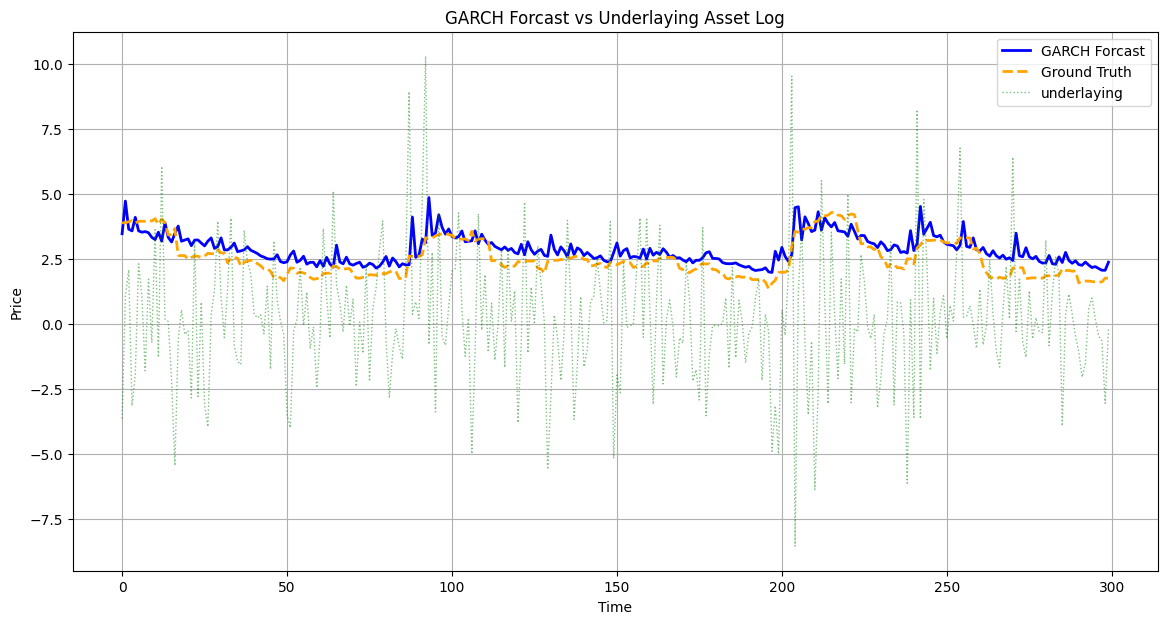

In [25]:

garch = arch_model(X_train, vol='GARCH', p=1, q=10, mean='Constant', dist='t')
forcast_vola = build_forcast_for_TIMESERIES_LENGTH(X_train, X_test, p=1, q=10)
# We will rescale the metrics to accuratly compare them with the LSTM model on their metrics. The Scale is now the original scale of the volatility.
forcast_vola_rescaled = forcast_vola.apply(lambda x: x/ SCALE_FACTOR)
test_vola_viz_rescaled = test_vola_viz.apply(lambda x: x/ SCALE_FACTOR)
# calculate MSE and MAE for the GARCH model
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(test_vola_viz_rescaled, forcast_vola_rescaled)
mae = mean_absolute_error(test_vola_viz_rescaled, forcast_vola_rescaled)
print(f"GARCH Model MSE: {mse}, MAE: {mae}")

# Visualise the GARCH model forecast
visualisation.visualize_forcast(forcast_vola, base_assest=X_test_viz, ground_trouth=test_vola_viz, label_forcast="GARCH Forcast", label_base_asset="underlaying", title="GARCH Forcast vs Underlaying Asset Log")

In [37]:
# Lets impove the GARCH model by using detrmining the ACF and PACF of the residuals
def evaluate_garch_model(train, p, q):
    """ Evaluate the GARCH model with the given parameters and return the fit and the implied volatility. """
    forcast_vola = build_forcast_for_TIMESERIES_LENGTH(X_train, X_test, p=p, q=q)
    # We will rescale the metrics to accuratly compare them with the LSTM model on their metrics. The Scale is now the original scale of the volatility.
    forcast_vola_rescaled = forcast_vola.apply(lambda x: x/ SCALE_FACTOR)
    test_vola_viz_rescaled = test_vola_viz.apply(lambda x: x/ SCALE_FACTOR)
    # calculate MSE and MAE for the GARCH model
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    mse = mean_squared_error(test_vola_viz_rescaled, forcast_vola_rescaled)
    mae = mean_absolute_error(test_vola_viz_rescaled, forcast_vola_rescaled)
    return mse, mae


evaluations = pd.DataFrame(columns=['p', 'q', 'MSE', 'MAE'])
i = 0
for p in range(1, 6):
    for q in range(1, 8):

        mse, mae = evaluate_garch_model(X_train, p, q)
        evaluations.loc[i] = [p, q, mse, mae]
        print("Evaluated GARCH model with p={}, q={} - MSE: {}, MAE: {}".format(p, q, mse, mae))
        i += 1

# plot the evaluations


Evaluated GARCH model with p=1, q=1 - MSE: 2.6665530535011193e-05, MAE: 0.00469079633480648
Evaluated GARCH model with p=1, q=2 - MSE: 2.603370175959552e-05, MAE: 0.004594707503959716
Evaluated GARCH model with p=1, q=3 - MSE: 2.6357018692695292e-05, MAE: 0.004455318348629467
Evaluated GARCH model with p=1, q=4 - MSE: 2.635711278898378e-05, MAE: 0.004455348353617315
Evaluated GARCH model with p=1, q=5 - MSE: 2.668579789728434e-05, MAE: 0.004458111763299299
Evaluated GARCH model with p=1, q=6 - MSE: 2.668562750647879e-05, MAE: 0.004458097695110715
Evaluated GARCH model with p=1, q=7 - MSE: 2.668494727354777e-05, MAE: 0.004458048917651983
Evaluated GARCH model with p=2, q=1 - MSE: 2.6666404176951837e-05, MAE: 0.004690849654577589
Evaluated GARCH model with p=2, q=2 - MSE: 2.6636847304621712e-05, MAE: 0.0046565369747535446
Evaluated GARCH model with p=2, q=3 - MSE: 2.5876992062287535e-05, MAE: 0.004438015399646772
Evaluated GARCH model with p=2, q=4 - MSE: 2.5877201708964727e-05, MAE: 0.0

/Users/orre/Documents/stuff/.venv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Evaluated GARCH model with p=5, q=4 - MSE: 2.6225889435955694e-05, MAE: 0.0045023837700573196
Evaluated GARCH model with p=5, q=5 - MSE: 2.6454044990648188e-05, MAE: 0.0044773938656802285
Evaluated GARCH model with p=5, q=6 - MSE: 2.6453794529267525e-05, MAE: 0.004477281957130195


/Users/orre/Documents/stuff/.venv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Evaluated GARCH model with p=5, q=7 - MSE: 2.674518074368223e-05, MAE: 0.004496537154483679


<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   p       35 non-null     float64
 1   q       35 non-null     float64
 2   MSE     35 non-null     float64
 3   MAE     35 non-null     float64
dtypes: float64(4)
memory usage: 2.4 KB
None
(5, 7)
(7,)
(5,)


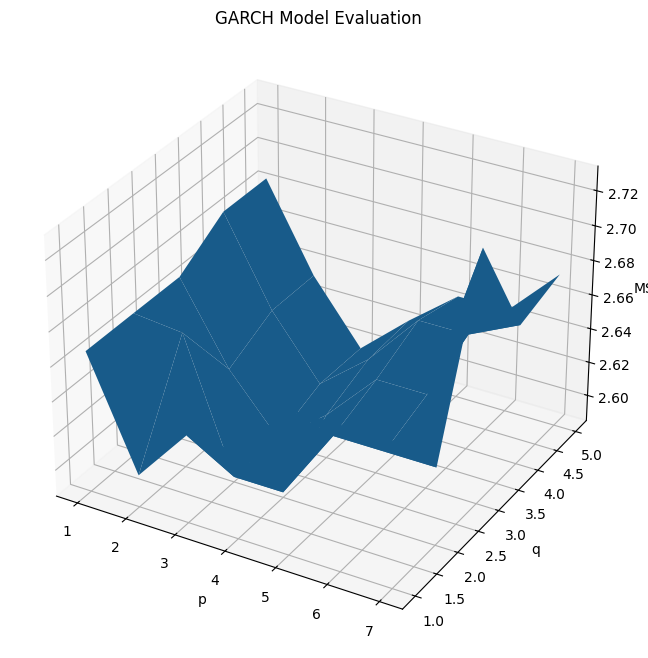

Best GARCH model: p=3.0, q=3.0 - MSE: 2.5876845607934922e-05, MAE: 0.004437988503793475
Best GARCH model: p=2.0, q=7.0 - MSE: 2.629966100954276e-05, MAE: 0.004435842383685624


In [53]:
def threed_visualize_evaluations(evaluations):
    """ Visualize the evaluations in a 3D plot. """
    import matplotlib.pyplot as plt
    Z = evaluations['MSE'].values.reshape(len(evaluations['p'].unique()), len(evaluations['q'].unique()))
    x = evaluations['q'].unique()
    y = evaluations['p'].unique()
    X, Y = np.meshgrid(x, y)
    print(Z.shape)
    print(x.shape)
    print(y.shape)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z)
    ax.set_xlabel('p')
    ax.set_ylabel('q')
    ax.set_zlabel('MSE')
    plt.title('GARCH Model Evaluation')
    plt.show()

print(evaluations.info())
threed_visualize_evaluations(evaluations)

def find_best_garch_model(evaluations):
    """ Find the best GARCH model based on the MSE. """
    best_model_MSE = evaluations.loc[evaluations['MSE'].idxmin()]
    print("Best GARCH model: p={}, q={} - MSE: {}, MAE: {}".format(best_model_MSE['p'], best_model_MSE['q'], best_model_MSE['MSE'], best_model_MSE['MAE']))
    best_model_MAE = evaluations.loc[evaluations['MAE'].idxmin()]
    print("Best GARCH model: p={}, q={} - MSE: {}, MAE: {}".format(best_model_MAE['p'], best_model_MAE['q'], best_model_MAE['MSE'], best_model_MAE['MAE']))
    return best_model_MSE, best_model_MAE
best_garch_model = find_best_garch_model(evaluations)